In [117]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree

In [118]:
def data_results(testing_classes, testing_inputs, alg_class):
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(testing_classes, alg_class.predict(testing_inputs))
    )

    cm_display.plot()
    plt.xticks([0, 1], ["No", "Yes"])
    plt.yticks([0, 1], ["No", "Yes"])
    plt.xlabel('Predicted Entry')
    plt.ylabel('Actual Entry')
    plt.show()

    print(classification_report(testing_classes, alg_class.predict(testing_inputs)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Feature: rank, Importance: 0.1382873172405567
Feature: won, Importance: 0.0
Feature: Cumulative PER, Importance: 0.36298918514291256
Feature: Cumulative Win Rate, Importance: 0.4987234976165308
4
    tmID   predict  predictNormalized
9    CHI  0.279070                  0
20   CON  1.000000                  1
30   DET  1.000000                  1
49   IND  1.000000                  1
82   NYL  0.279070                  0
138  WAS  0.833333                  1
    tmID   predict  predictNormalized
40   HOU  0.833333                  1
59   LAS  0.000000                  0
72   MIN  0.279070                  0
95   PHO  0.882353                  1
108  SAC  0.833333                  1
115  SAS  0.279070                  0
125  SEA  1.000000                  1


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_17608\2756398746.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_test['predict'] = probs
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_17608\2756398746.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_test['predictNormalized'] = (df_teams_test.groupby('confID')['predict'].rank(method='first', ascending=False) <= 4).astype(int)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_17608\2756398746.py:51: SettingWithCopyWarning: 
A valu

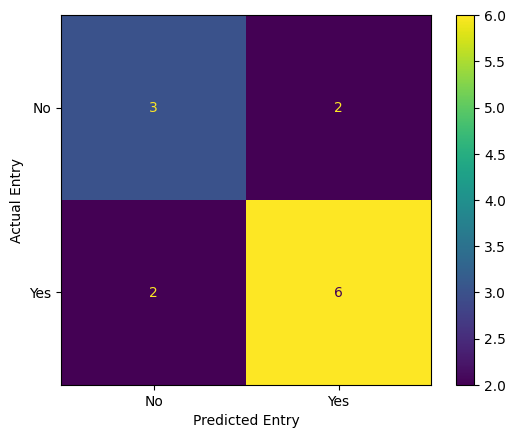

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.75      0.75      0.75         8

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13



In [119]:
df_teams = pd.read_csv('dataset/processed/teams_test.csv')
df_teams = df_teams.sort_values(by=['franchID', 'year'])
df_teams['playoffNextYear'] = df_teams['playoff'].shift(-1)
df_teams.loc[df_teams['franchID'] != df_teams['franchID'].shift(-1), 'playoffNextYear'] = None
df_teams.dropna(subset=['playoffNextYear'], inplace=True)
label_encoder_tmID = LabelEncoder()
label_encoder_playoff = LabelEncoder()
label_encoder_playoffNextYear = LabelEncoder()

df_teams['playoff'] = label_encoder_playoff.fit_transform(df_teams['playoff'])
df_teams['playoffNextYear'] = label_encoder_playoffNextYear.fit_transform(df_teams['playoffNextYear'])
features = ['rank', 'won', 'Cumulative PER', 'Cumulative Win Rate'] # attend?

df_teams_train = df_teams[df_teams['year'] <= 6]
df_teams_test = df_teams[df_teams['year'].isin([7])]

training_inputs = df_teams_train[features]
training_classes = df_teams_train['playoffNextYear']
testing_inputs = df_teams_test[features]
testing_classes = df_teams_test['playoffNextYear']

dt_class = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=dt_class,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(training_inputs, training_classes)

best_model = grid_search.best_estimator_

importance = best_model.feature_importances_
for feature, imp in zip(features, importance):
    print(f"Feature: {feature}, Importance: {imp}")

probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
df_teams_test['predict'] = probs
df_teams_test['predictNormalized'] = (df_teams_test.groupby('confID')['predict'].rank(method='first', ascending=False) <= 4).astype(int)
df_teams_test['result'] = abs(df_teams_test['predictNormalized'] - df_teams_test['playoffNextYear'])
print(df_teams_test['result'].sum())
print(df_teams_test.loc[df_teams_test['confID']=="EA", ['tmID', 'predict', 'predictNormalized']])
print(df_teams_test.loc[df_teams_test['confID']=="WE", ['tmID', 'predict', 'predictNormalized']])
#print(tmID_label_mapping)

data_results(testing_classes, testing_inputs, best_model)

# plot_tree(dt_class, feature_names=features, filled=True)

In [120]:
'''rf_class = RandomForestClassifier(n_estimators=100)
rf_class.fit(training_inputs, training_classes)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

grid_search = GridSearchCV(estimator=rf_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(training_inputs, training_classes)
best_model = grid_search.best_estimator_
best_model.predict(testing_inputs)

best_model.score(testing_inputs, testing_classes)

probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
df_teams_test['predict'] = probs
df_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])
print(df_teams_test['result'].sum())
accuracy_score(testing_classes, best_model.predict(testing_inputs))

data_results(testing_classes, testing_inputs, best_model)'''

"rf_class = RandomForestClassifier(n_estimators=100)\nrf_class.fit(training_inputs, training_classes)\n\nparam_grid = {\n    'n_estimators': [100, 200],\n    'max_depth': [10, 20, None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['sqrt', 'log2', None],\n}\n\ngrid_search = GridSearchCV(estimator=rf_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)\ngrid_search.fit(training_inputs, training_classes)\nbest_model = grid_search.best_estimator_\nbest_model.predict(testing_inputs)\n\nbest_model.score(testing_inputs, testing_classes)\n\nprobs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]\ndf_teams_test['predict'] = probs\ndf_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])\nprint(df_teams_test['result'].sum())\naccuracy_score(testing_classes, best_model.predict(testing_inputs))\n\ndata_results(testing_classes, testing_inputs, best_model)"

In [121]:
'''nb_class = GaussianNB()
nb_class.fit(training_inputs, training_classes)

nb_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, nb_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, nb_class)'''

'nb_class = GaussianNB()\nnb_class.fit(training_inputs, training_classes)\n\nnb_class.score(testing_inputs, testing_classes)\n\naccuracy_score(testing_classes, nb_class.predict(testing_inputs))\n\ndata_results(testing_classes, testing_inputs, nb_class)'

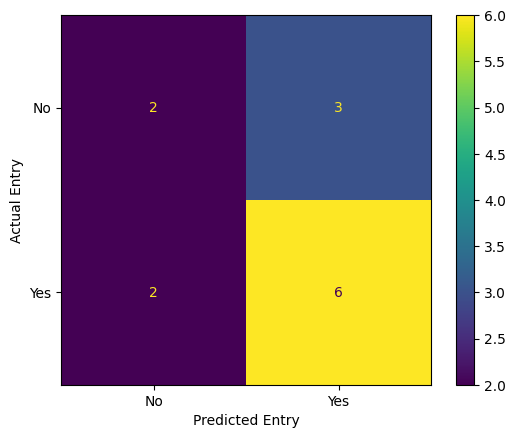

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



In [122]:
svm_class = SVC(kernel='rbf', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [1, 0.1, 0.01, 0.001],
}

grid_search = GridSearchCV(estimator=svm_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(training_inputs, training_classes)
best_model = grid_search.best_estimator_
accuracy_score(testing_classes, best_model.predict(testing_inputs))

data_results(testing_classes, testing_inputs, best_model)

In [123]:
'''knn_class = KNeighborsClassifier(n_neighbors=13, algorithm='auto', metric='minkowski', p=1, weights='distance')

knn_class.fit(training_inputs, training_classes)

knn_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, knn_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, knn_class)'''

"knn_class = KNeighborsClassifier(n_neighbors=13, algorithm='auto', metric='minkowski', p=1, weights='distance')\n\nknn_class.fit(training_inputs, training_classes)\n\nknn_class.score(testing_inputs, testing_classes)\n\naccuracy_score(testing_classes, knn_class.predict(testing_inputs))\n\ndata_results(testing_classes, testing_inputs, knn_class)"

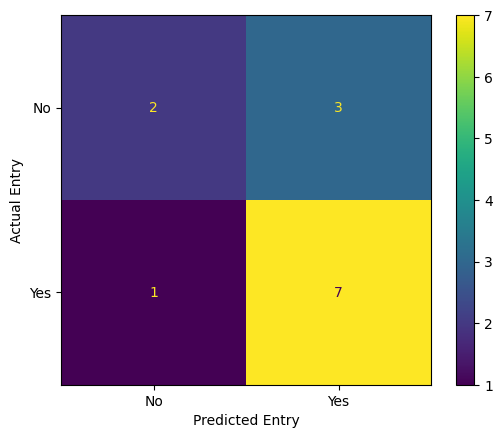

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



In [124]:
ab_class = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)

ab_class.fit(training_inputs, training_classes)
ab_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ab_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ab_class)

ValueError: x and y must have same first dimension, but have shapes (7,) and (4,)

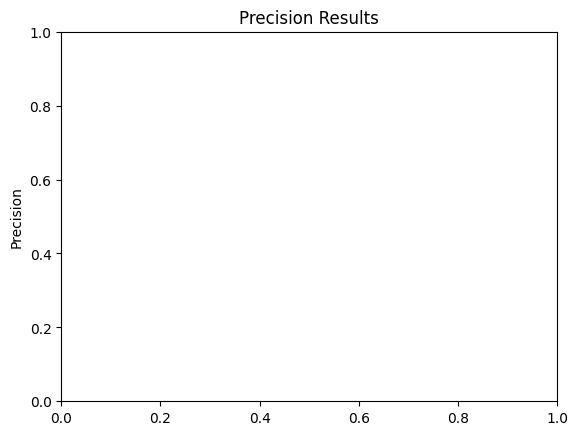

In [ ]:
years = range(3, 10)
precision_dt = [0.56, 0.31, 0.22, 0.55, 0.68]
precision_svm = [0.68, 0.68, 0.35, 0.45, 0.58]
precision_ab = [0.56, 0.58, 0.42, 0.65, 0.68]
#error_stats = [6, 8, 8, 6, 4]

plt.figure()
#plt.plot(years, precision_dt, label='Precision')
plt.title('Precision Results')
plt.ylabel('Precision')
plt.plot(years, precision_dt, label='Precision (DT)')
plt.plot(years, precision_svm, label='Precision (SVM)')
plt.plot(years, precision_ab, label='Precision (AB)')
#plt.title('Error (Normalized)')
#plt.ylabel('Error')
plt.xlabel('Year')
plt.xticks(range(3, 10))
plt.xlim(3, 9)
plt.ylim(0, 1)
#plt.ylim(0, 12)
plt.legend(loc='lower right')
plt.show()